In [1]:
import requests
import json
from csv import writer

# Filter the locations where primary schools are
url_prsc = 'https://services6.arcgis.com/GB33F62SbDxJjwEL/ArcGIS/rest/services/Vicmap_Features_of_Interest/FeatureServer/8/query?where=FEATURE_CODE+%3D+%27PRSC%27+&objectIds=&time=&geometry=&geometryType=esriGeometryPolygon&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&relationParam=&returnGeodetic=false&outFields=&returnGeometry=true&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=&defaultSR=&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pgeojson&token='
url_sesc = 'https://services6.arcgis.com/GB33F62SbDxJjwEL/ArcGIS/rest/services/Vicmap_Features_of_Interest/FeatureServer/8/query?where=FEATURE_CODE+%3D+%27SESC%27+&objectIds=&time=&geometry=&geometryType=esriGeometryPolygon&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&relationParam=&returnGeodetic=false&outFields=&returnGeometry=true&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=&defaultSR=&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pgeojson&token='
#url_uni = ''
url_park = 'https://services6.arcgis.com/GB33F62SbDxJjwEL/ArcGIS/rest/services/Vicmap_Features_of_Interest/FeatureServer/8/query?where=FEATURE_CODE+%3D+%27PARK%27+&objectIds=&time=&geometry=&geometryType=esriGeometryPolygon&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&relationParam=&returnGeodetic=false&outFields=&returnGeometry=true&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=&defaultSR=&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pgeojson&token='

url_list= [url_prsc, url_sesc, url_park]
name_list = ['primary_school', 'secondary_school', 'park']

for j in range(len(url_list)):
    resp = requests.get(url=url_list[j])
    
    # Name the csv file
    csv_name = str(name_list[j]) + '.csv'

    content = json.loads(resp.text)
    
    # Get request for each property ID and extract attributes

    for i in content['features']:
        place_name = i['properties']['PLACE_NAME']
        longitude = i['geometry']['coordinates'][0]
        latitude = i['geometry']['coordinates'][1]

        info = [place_name, latitude, longitude]
    
        with open(csv_name, 'a', newline='') as g:
            thewriter = writer(g)        
            thewriter.writerow(info)

       MB_CODE_2021 MB_CATEGORY_2021 CHANGE_FLAG_2021 CHANGE_LABEL_2021  \
112738  20000010000        Education                0         No change   
112739  20000021000       Commercial                0         No change   
112740  20000022000       Commercial                0         No change   
112741  20000023000       Commercial                0         No change   
112742  20000031000       Commercial                0         No change   

       SA1_CODE_2021 SA2_CODE_2021          SA2_NAME_2021 SA3_CODE_2021  \
112738   20403106914     204031069  Bright - Mount Beauty         20403   
112739   20403106902     204031069  Bright - Mount Beauty         20403   
112740   20403106902     204031069  Bright - Mount Beauty         20403   
112741   20403106902     204031069  Bright - Mount Beauty         20403   
112742   20403106902     204031069  Bright - Mount Beauty         20403   

           SA3_NAME_2021 SA4_CODE_2021 SA4_NAME_2021 GCCSA_CODE_2021  \
112738  Wodonga - Alpine  

<Figure size 3600x2880 with 0 Axes>

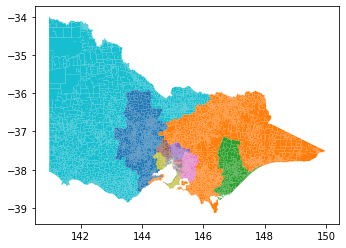

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt

filename = '../../data/raw/ASGS_2021_Main_Structure_GDA2020.gpkg'
gdf = gpd.read_file(filename)


# Extract the data only for Victoria
gdf_vic_only = gdf[gdf['STATE_NAME_2021'] == 'Victoria']

# Get the size of the image right 
plt.figure(figsize=(50, 40))
# Plot Victoria
gdf_vic_only.plot(column = 'SA2_CODE_2021')

plt.savefig("Victoria_SA2.png", dpi = 800)

print(gdf_vic_only.head())

In [22]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

rental_history = spark.read.csv("../../data/raw/Rental price VIC SA2 2000 2021.csv", header=True)
convert2016to2021 = spark.read.csv("../../data/raw/external_dataset/sa2_2016_to_2021.csv", header=True)

# Victoria state data only
df = rental_history.filter(rental_history['state'] == 'VIC')

# Dateyear after 2010 only
df = df.withColumn("dateyear",df["dateyear"].cast(IntegerType()))
df = df[df['dateyear'] > 2010]

# Extract rental price related attributes only
df = df.select('dateyear', 'datemonth', 'sa22016name', 'sa22016code', 'propertycategorisation', 'for_rent_home_lease_averageprice', 'for_rent_home_lease_maximumprice', 'for_rent_home_lease_minimumprice')
df = df.sort(df["dateyear"].asc())
# Write and save it 

# Convert 2016 SA2 codes to 2022 SA2 codes
df = df.join(convert2016to2021, convert2016to2021.SA2_MAINCODE_2016 ==  df.sa22016code).\
    select(df.dateyear, df.datemonth, convert2016to2021.SA2_CODE_2021, convert2016to2021.SA2_NAME_2021, df.propertycategorisation, \
    df.for_rent_home_lease_averageprice, df.for_rent_home_lease_maximumprice, df.for_rent_home_lease_minimumprice).\
    sort("dateyear", 'datemonth')

df = df.na.drop()
df.write.csv("../../data/curated/rental_history_Vic.csv")

